In [1]:
import cv2 
import numpy as np 
import edgeDetection as edge 
import matplotlib.pyplot as plt 

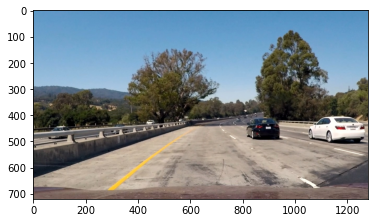

In [2]:
# Load the image (test1)
filename = 'test1.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

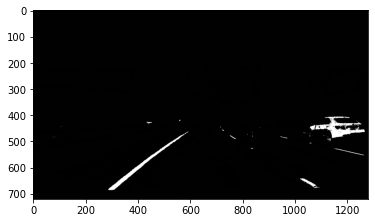

In [3]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(180, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (150, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(200, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

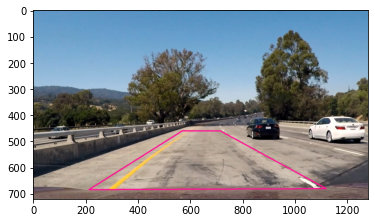

In [4]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

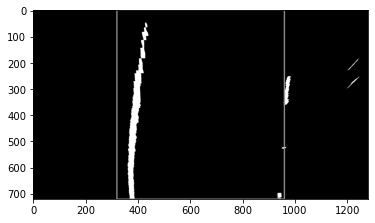

In [5]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

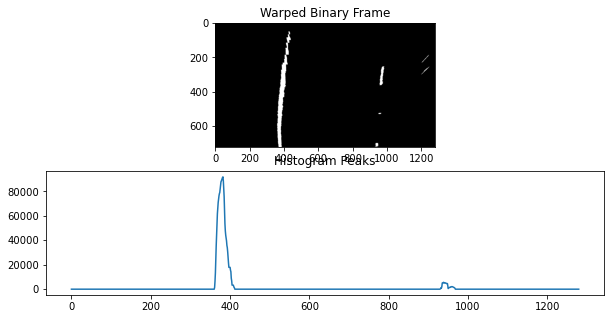

In [6]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

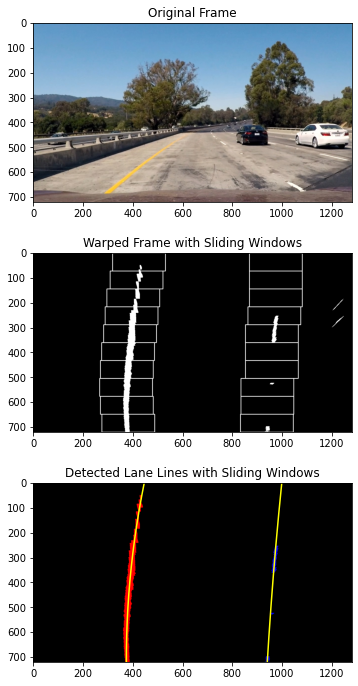

In [7]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

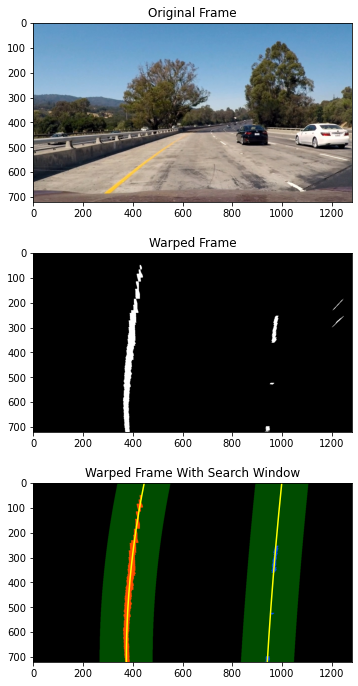

In [8]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

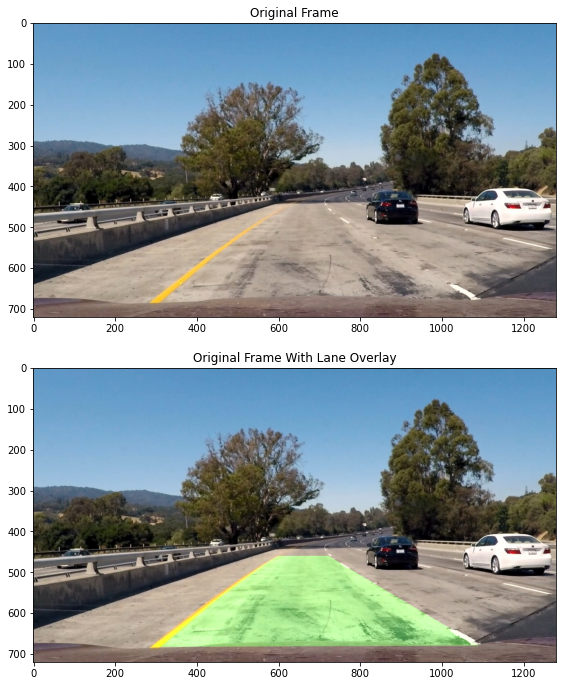

In [9]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [10]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 73.85407120102911m.
Right lane curvature= 360.20847907101887m.
The radius of curvature= 217.031275136024m.


In [11]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.08157021388077526m left of center.


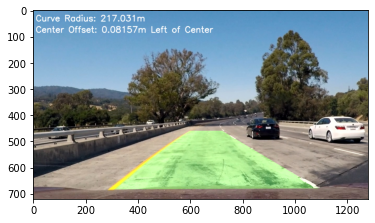

In [12]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()

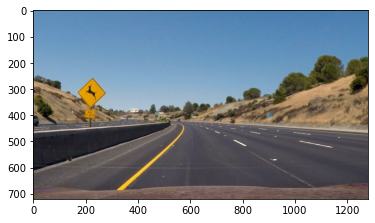

In [13]:
# Load the image (test2)
filename = 'test2.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

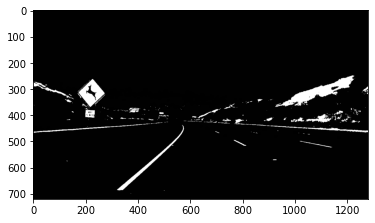

In [14]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(180, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (20, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(180, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

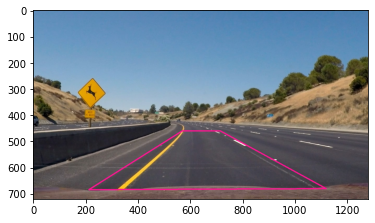

In [15]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

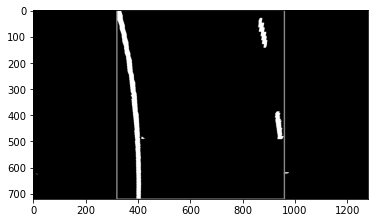

In [16]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

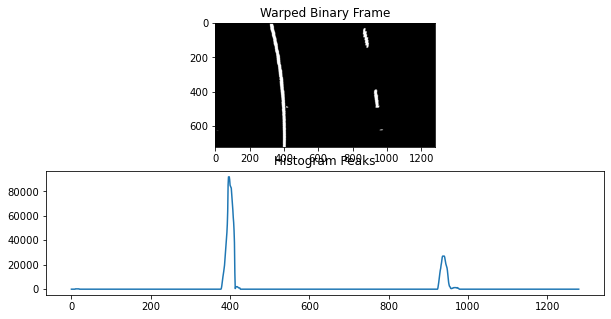

In [17]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

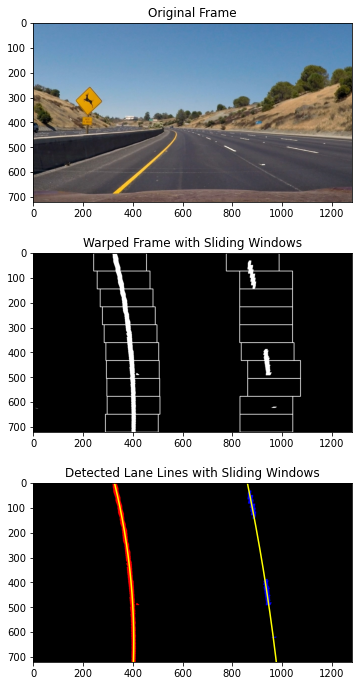

In [18]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

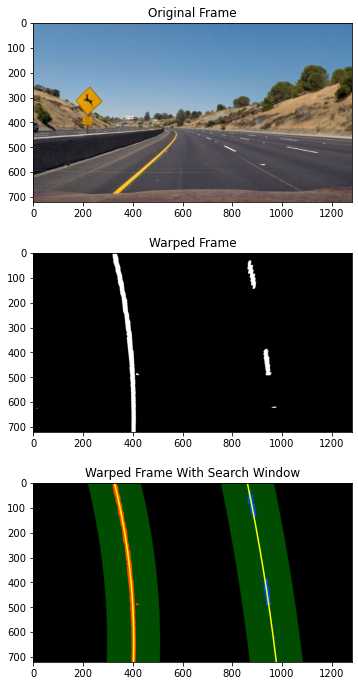

In [19]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

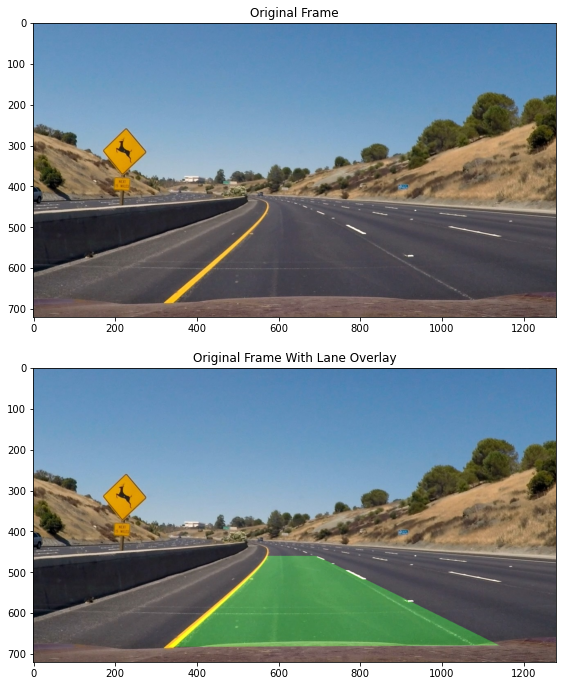

In [20]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [21]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 55.30488630363746m.
Right lane curvature= 176.838395155925m.
The radius of curvature= 116.07164072978124m.


In [22]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.2345157968154317m left of center.


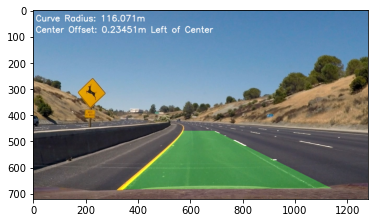

In [23]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()

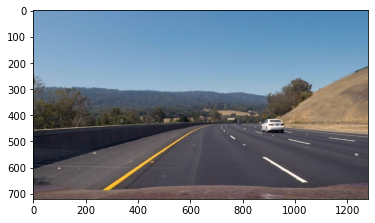

In [24]:
# Load the image (test3)
filename = 'test3.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

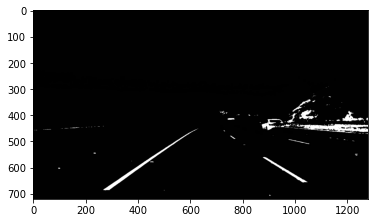

In [25]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(180, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (20, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(180, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

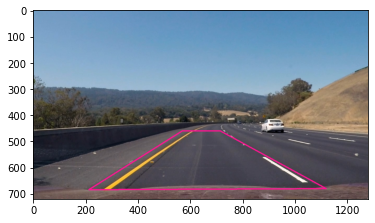

In [26]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

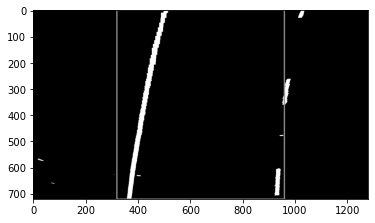

In [27]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

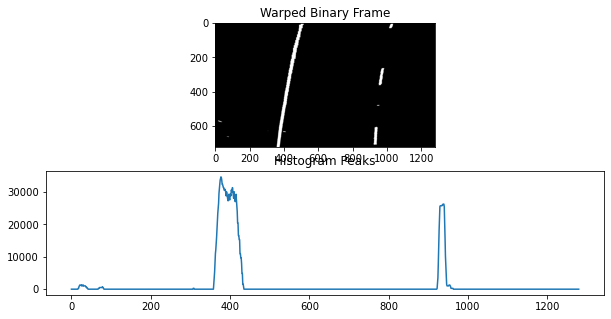

In [28]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

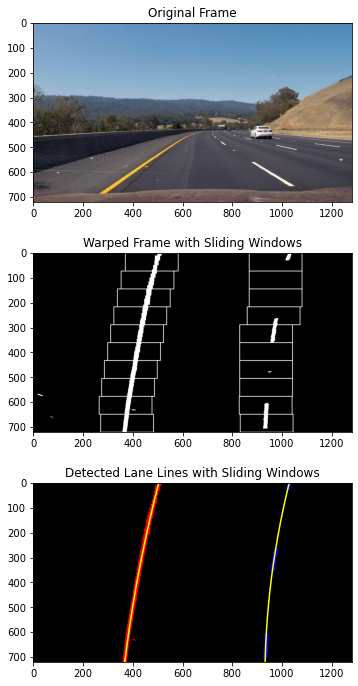

In [29]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

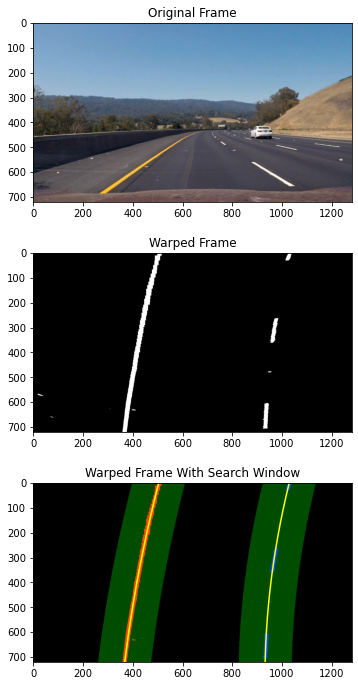

In [30]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

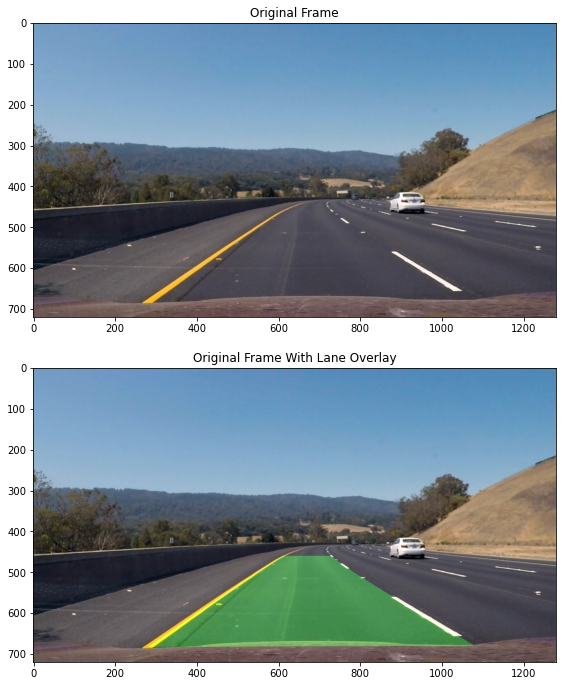

In [31]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [32]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 113.28306411403085m.
Right lane curvature= 67.93562202314271m.
The radius of curvature= 90.60934306858678m.


In [33]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.045937314055673945m left of center.


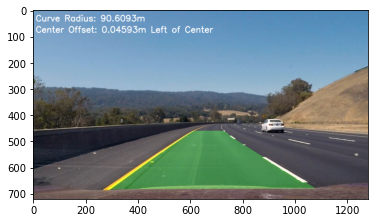

In [34]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()

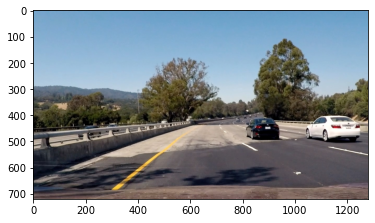

In [35]:
# Load the image (test4)
filename = 'test4.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

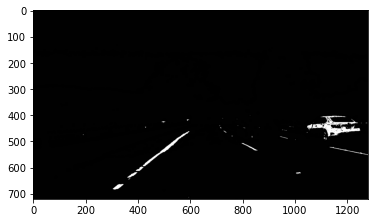

In [36]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(180, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (140, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(220, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

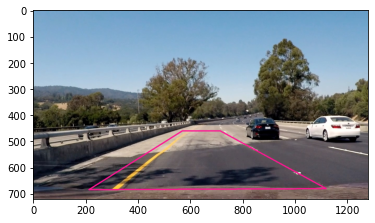

In [37]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

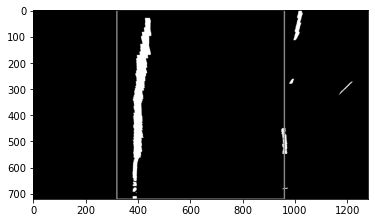

In [38]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

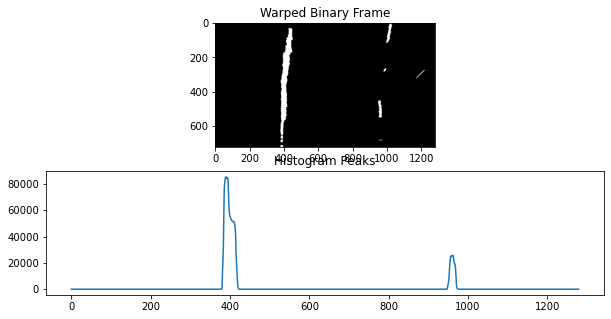

In [39]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

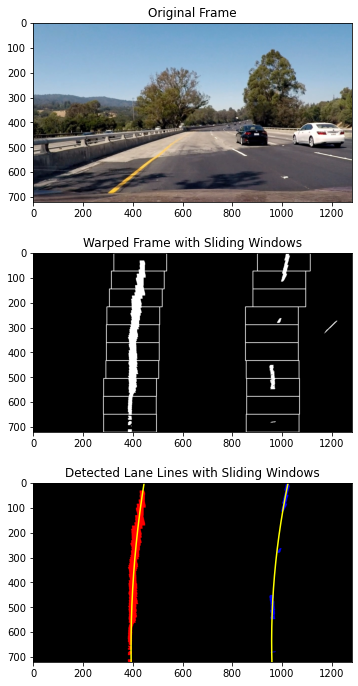

In [40]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

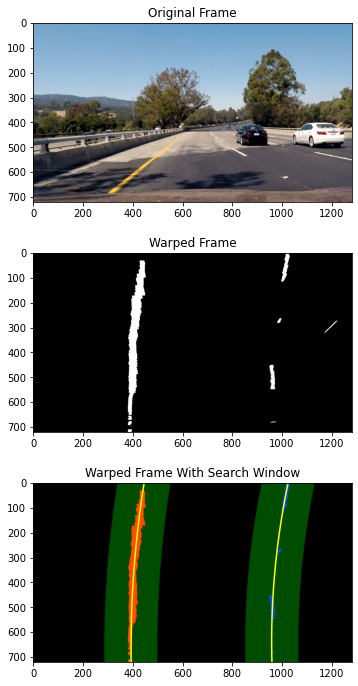

In [41]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

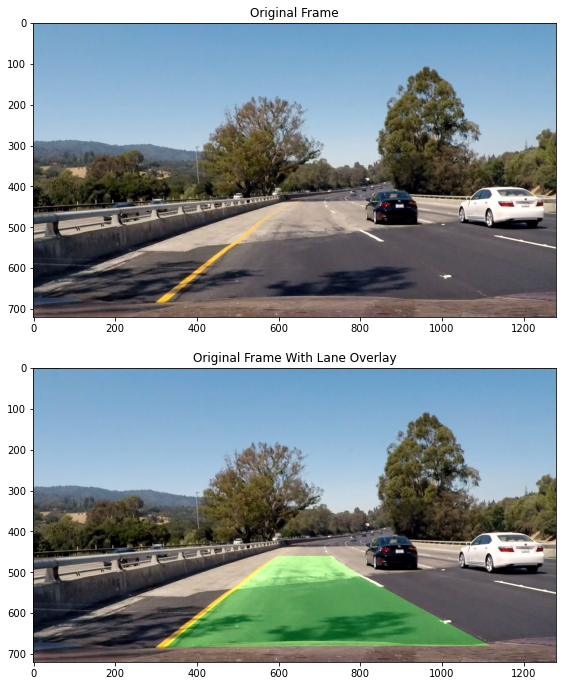

In [42]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [43]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 87.14333689358263m.
Right lane curvature= 65.02973691086348m.
The radius of curvature= 76.08653690222306m.


In [44]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.17112796593483726m left of center.


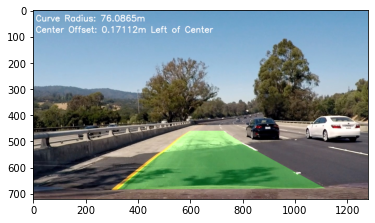

In [45]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()

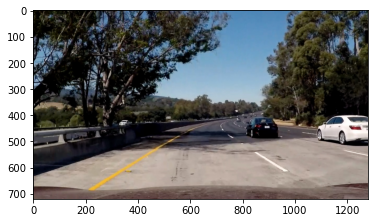

In [46]:
# Load the image (test5)
filename = 'test5.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

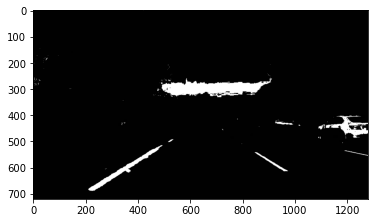

In [47]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(230, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (80, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(150, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

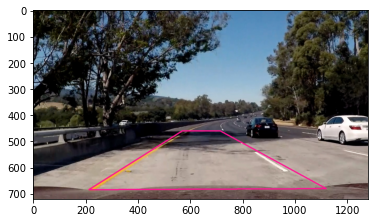

In [48]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

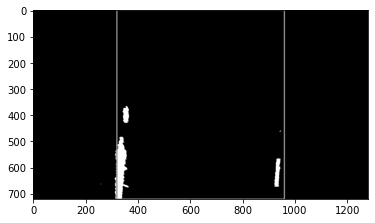

In [49]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

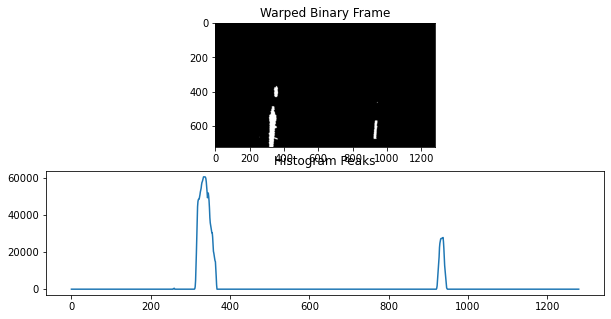

In [50]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

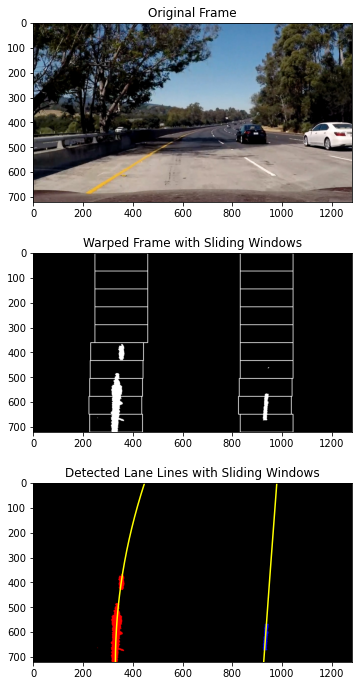

In [51]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

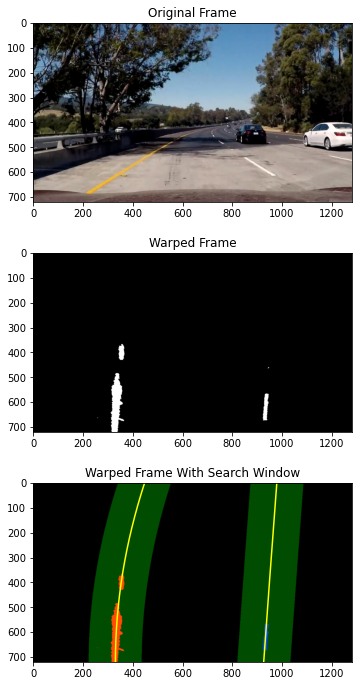

In [52]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

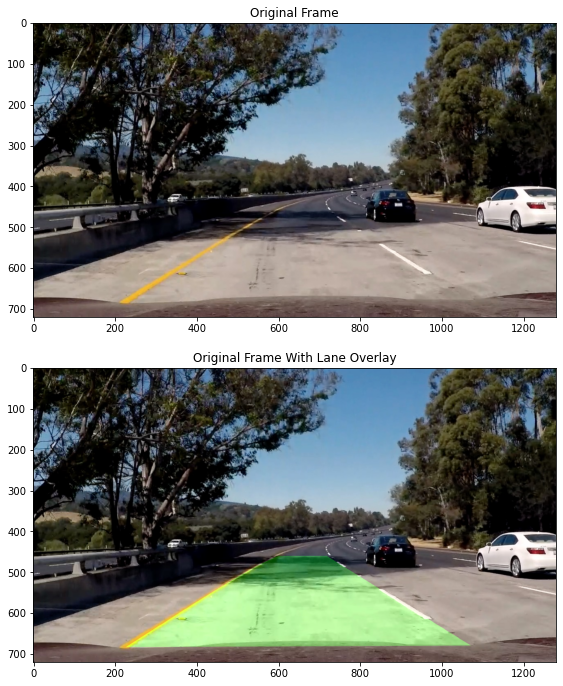

In [53]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [54]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 46.986139537963645m.
Right lane curvature= 3401.4743695444113m.
The radius of curvature= 1724.2302545411874m.


In [55]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.05717200977740218m right of center.


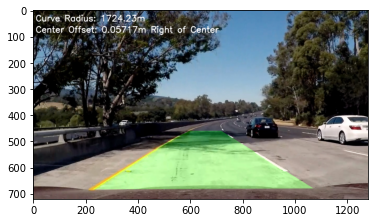

In [56]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()

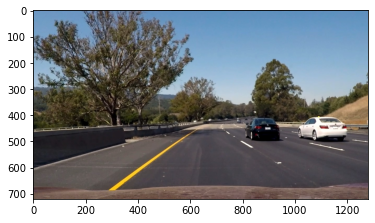

In [57]:
# Load the image (test6)
filename = 'test6.jpg'
imgbgr = cv2.imread(filename)
origImageSize = imgbgr.shape[::-1][1:]
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

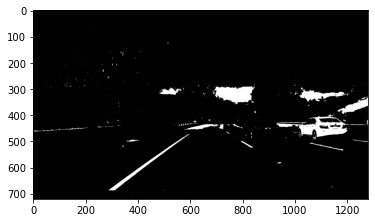

In [58]:
# change the image to binary color only black and white
hls = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2HLS)
_, sxbinary = edge.threshold(hls[:, :, 1], thresh=(180, 255))
sxbinary = edge.blurGaussian(sxbinary, ksize=3)
sxbinary = edge.magThresh(sxbinary, sobelKernel=3, thresh=(110, 255))
sChannel = hls[:, :, 2] 
_, sBinary = edge.threshold(sChannel, (20, 255))
_, rThresh = edge.threshold(imgbgr[:, :, 2], thresh=(180, 255))
rsBinary = cv2.bitwise_and(sBinary, rThresh)
laneLineMarkings = cv2.bitwise_or(rsBinary, sxbinary.astype(np.uint8)) 
plt.imshow(cv2.cvtColor(laneLineMarkings, cv2.COLOR_BGR2RGB))
plt.show()

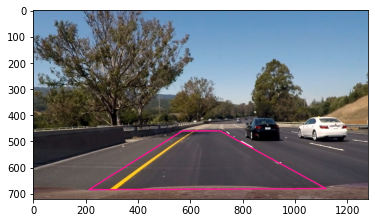

In [59]:
# Place the region of interest (ROI) on the image
roiPoints = np.float32([
      (570,460),
      (213,684),
      (1120,680),
      (715,460)
      ])
imgbgrCopy = imgbgr.copy()
thisImage = cv2.polylines(imgbgrCopy, np.int32([roiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(thisImage, cv2.COLOR_BGR2RGB))
plt.show()

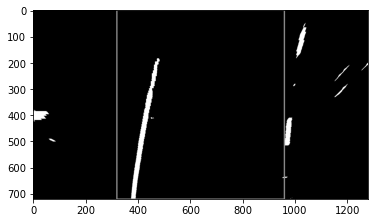

In [60]:
desiredRoiPoints = np.float32([
    [320, 0],
    [320, origImageSize[1]],        
    [origImageSize[0]-320, origImageSize[1]],
    [origImageSize[0]-320, 0]
]) 
transformationMatrix = cv2.getPerspectiveTransform(roiPoints, desiredRoiPoints)
invTransformationMatrix = cv2.getPerspectiveTransform(desiredRoiPoints, roiPoints)
warpedFrame = cv2.warpPerspective(laneLineMarkings, transformationMatrix, origImageSize, flags=(cv2.INTER_LINEAR))
(thresh, binaryWarped) = cv2.threshold(warpedFrame, 127, 255, cv2.THRESH_BINARY)
warpedFrame = binaryWarped.copy()
warpedPlot = cv2.polylines(binaryWarped, np.int32([desiredRoiPoints]), True, (147,20,255), 3)
plt.imshow(cv2.cvtColor(warpedPlot, cv2.COLOR_BGR2RGB))
plt.show()

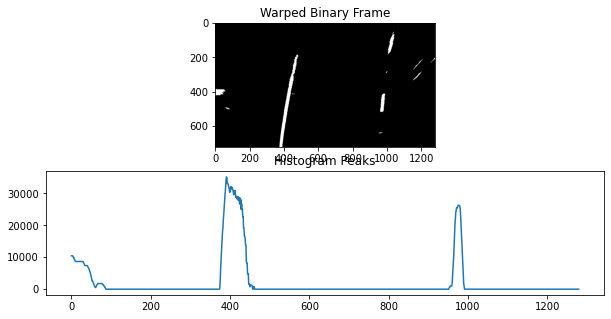

In [61]:
histogram = np.sum(warpedFrame[int(warpedFrame.shape[0]/2):,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(10, 5)
ax1.imshow(warpedFrame, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")
plt.show()

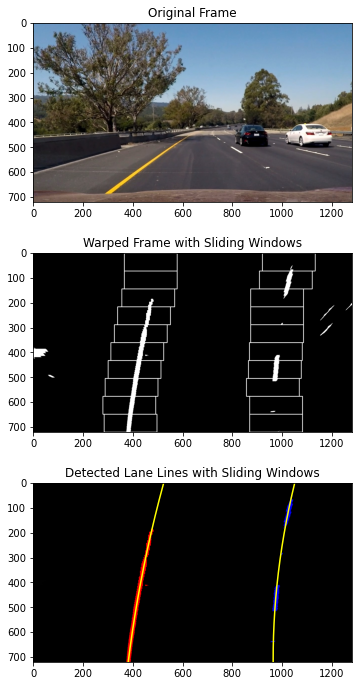

In [62]:
# Get the indices of the lane line pixels using the sliding windows technique
margin = int((1/12) * origImageSize[0])
noOfWindows = 10
frameSlidingWindow = warpedFrame.copy()
windowHeight = np.int(warpedFrame.shape[0]/noOfWindows)
nonzero = warpedFrame.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftLaneInds = []
rightLaneInds = []
midpoint = np.int(histogram.shape[0]/2)
leftxBase = np.argmax(histogram[:midpoint])
rightxBase = np.argmax(histogram[midpoint:]) + midpoint
leftxCurrent = leftxBase
rightxCurrent = rightxBase
for window in range(noOfWindows):
    winYLow = warpedFrame.shape[0] - (window + 1) * windowHeight
    winYHigh = warpedFrame.shape[0] - window * windowHeight
    winXleftLow = leftxCurrent - margin
    winXleftHigh = leftxCurrent + margin
    winXrightLow = rightxCurrent - margin
    winXrightHigh = rightxCurrent + margin
    cv2.rectangle(frameSlidingWindow,(winXleftLow,winYLow),(winXleftHigh,winYHigh), (255,255,255), 2)
    cv2.rectangle(frameSlidingWindow,(winXrightLow,winYLow),(winXrightHigh,winYHigh), (255,255,255), 2)
    goodLeftInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXleftLow) & (
        nonzerox < winXleftHigh)).nonzero()[0]
    goodRightInds = ((nonzeroy >= winYLow) & (nonzeroy < winYHigh) & (nonzerox >= winXrightLow) & (
        nonzerox < winXrightHigh)).nonzero()[0]
    leftLaneInds.append(goodLeftInds)
    rightLaneInds.append(goodRightInds)
    minpix = int((1/24) * origImageSize[0])
    if len(goodLeftInds) > minpix:
        leftxCurrent = np.int(np.mean(nonzerox[goodLeftInds]))
    if len(goodRightInds) > minpix:        
        rightxCurrent = np.int(np.mean(nonzerox[goodRightInds]))
leftLaneInds = np.concatenate(leftLaneInds)
rightLaneInds = np.concatenate(rightLaneInds)
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds] 
righty = nonzeroy[rightLaneInds]
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2) 
ploty = np.linspace(0, frameSlidingWindow.shape[0]-1, warpedFrame.shape[0])
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
outImg = np.dstack((frameSlidingWindow, frameSlidingWindow, (frameSlidingWindow))) * 255
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(frameSlidingWindow, cmap='gray')
ax3.imshow(outImg)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame with Sliding Windows")
ax3.set_title("Detected Lane Lines with Sliding Windows")
plt.show()        

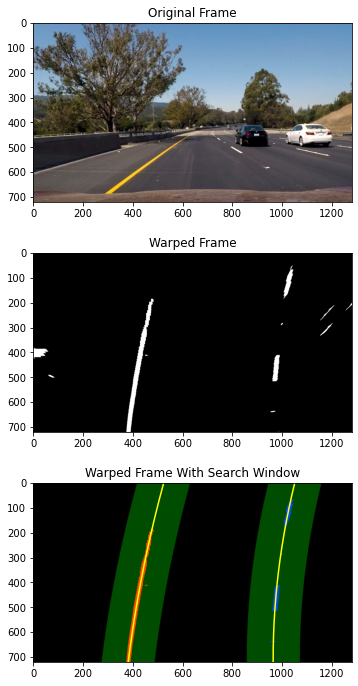

In [63]:
# Use the lane line from the previous sliding window to get the parameters for the polynomial line for filling in the lane line         
leftLaneInds = ((nonzerox > (leftFit[0]*(nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] - margin)) & (nonzerox < (leftFit[0]*(
    nonzeroy**2) + leftFit[1]*nonzeroy + leftFit[2] + margin))) 
rightLaneInds = ((nonzerox > (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] - margin)) & (nonzerox < 
    (rightFit[0]*(nonzeroy**2) + rightFit[1]*nonzeroy + rightFit[2] + margin)))           
leftx = nonzerox[leftLaneInds]
lefty = nonzeroy[leftLaneInds] 
rightx = nonzerox[rightLaneInds]
righty = nonzeroy[rightLaneInds]  
leftFit = np.polyfit(lefty, leftx, 2)
rightFit = np.polyfit(righty, rightx, 2)
ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0]) 
leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]         
outImg = np.dstack((warpedFrame, warpedFrame, (warpedFrame)))*255
windowImg = np.zeros_like(outImg)
outImg[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
outImg[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [0, 0, 255]
leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
figure, (ax1, ax2, ax3) = plt.subplots(3,1)
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(imgrgb)
ax2.imshow(warpedFrame, cmap='gray')
ax3.imshow(result)
ax3.plot(leftFitx, ploty, color='yellow')
ax3.plot(rightFitx, ploty, color='yellow')
ax1.set_title("Original Frame")  
ax2.set_title("Warped Frame")
ax3.set_title("Warped Frame With Search Window")
plt.show()

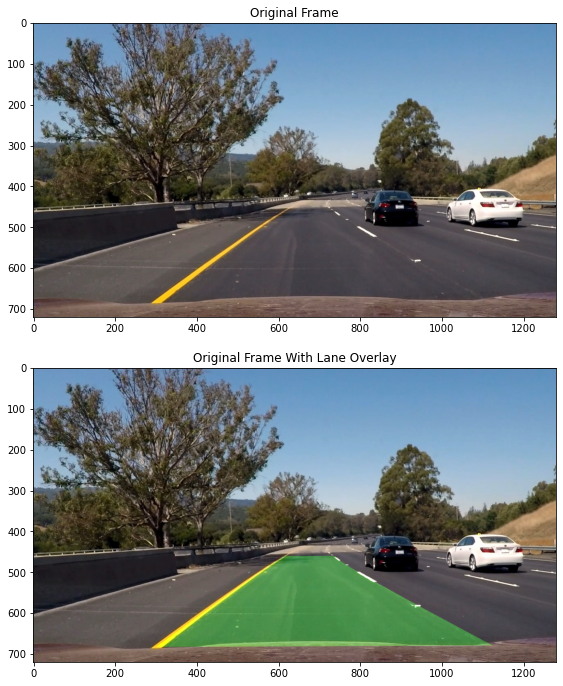

In [64]:
# Overlay lane lines on the original frame
warpZero = np.zeros_like(warpedFrame).astype(np.uint8)
colorWarp = np.dstack((warpZero, warpZero, warpZero))       
ptsLeft = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
pts = np.hstack((ptsLeft, ptsRight))
cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(colorWarp, invTransformationMatrix, (imgbgr.shape[1], imgbgr.shape[0]))
result = cv2.addWeighted(imgbgr, 1, newwarp, 0.3, 0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
figure.set_size_inches(10, 10)
figure.tight_layout(pad=3.0)
ax1.imshow(cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax1.set_title("Original Frame")  
ax2.set_title("Original Frame With Lane Overlay")
plt.show()   

In [65]:
# Calculate the road curvature in meters.
YMPERPIX = 10.0 / 1000 
XMPERPIX = 3.7 / 781 
yEval = np.max(ploty)    
leftFitCr = np.polyfit(lefty * YMPERPIX, leftx * (XMPERPIX), 2)
rightFitCr = np.polyfit(righty * YMPERPIX, rightx * (XMPERPIX), 2)
leftCurvem = ((1 + (2*leftFitCr[0]*yEval*YMPERPIX + leftFitCr[1])**2)**1.5) / np.absolute(2*leftFitCr[0])
rightCurvem = ((1 + (2*rightFitCr[0]*yEval*YMPERPIX + rightFitCr[1])**2)**1.5) / np.absolute(2*rightFitCr[0])
print(f"Left lane curvature= {leftCurvem}m.")
print(f"Right lane curvature= {rightCurvem}m.")
print(f"The radius of curvature= {(leftCurvem+rightCurvem)/2}m.")

Left lane curvature= 102.51359188716613m.
Right lane curvature= 61.14532811822909m.
The radius of curvature= 81.8294600026976m.


In [66]:
# Calculate the position of the car relative to the center
carLocation = imgbgr.shape[1] / 2
height = imgbgr.shape[0]
bottomLeft = leftFit[0]*height**2 + leftFit[1]*height + leftFit[2]
bottomRight = rightFit[0]*height**2 + rightFit[1]*height + rightFit[2]
centerLane = (bottomRight - bottomLeft)/2 + bottomLeft 
centerOffset = (np.abs(carLocation) - np.abs(centerLane)) * XMPERPIX
offsetStr = ""
if (centerOffset < 0):
    offsetStr = "left of center"
elif (centerOffset > 0):
    offsetStr = "right of center"
print(f"Center offset= {np.abs(centerOffset)}m {offsetStr}.")

Center offset= 0.15527635172854296m left of center.


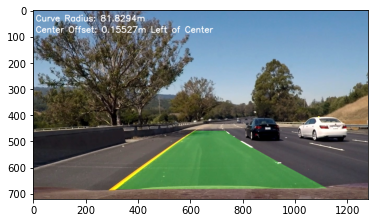

In [67]:
# Display curvature and offset statistics on the image (Final image to be shown)
finalVersion = result.copy()
cv2.putText(finalVersion,'Curve Radius: '+str((leftCurvem+rightCurvem)/2)[:7]+'m', (int((5/600)*origImageSize[0]), int((
  20/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
offsetStr = ""
if (centerOffset < 0):
    offsetStr = " Left of Center"
elif (centerOffset > 0):
    offsetStr = " Right of Center"
cv2.putText(finalVersion,'Center Offset: '+str(np.abs(centerOffset))[:7]+'m'+offsetStr, (int((5/600)*origImageSize[0]), int((
  40/338)*origImageSize[1])), cv2.FONT_HERSHEY_SIMPLEX, (float((0.5/600)*origImageSize[0])),(255,255,255),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(finalVersion, cv2.COLOR_BGR2RGB))
plt.show()